In [1]:
import functions

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from parameters.flopping_spin import * # change here to change the device: charge_qubit, flopping_spin, flopping_charge, transmon, fluxonium

plt.rcParams['text.usetex'] = True
params = {
    "backend": "ps",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "legend.frameon": True,
    "savefig.dpi": 100,
    "axes.linewidth": 1.5,
    'xtick.major.size' : 10,
    'xtick.major.width': 1,
    'xtick.minor.size': 7,
    'xtick.minor.width': 1,
    'ytick.major.size' : 10,
    'ytick.major.width': 1,
    'ytick.minor.size': 7,
    'ytick.minor.width': 1,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
}
plt.rcParams.update(params)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('text', usetex=True)

In [2]:
A_q = 0.2*wq

############################# Set compensation True/False ##############################
compensation = False

############################# Parameters for longitudinal readout ##############################
w_r=[1.4*wq]

A_list, dd_real, dd2_real = functions.get_derivatives(N_rep,A_q,H_sys,drive_op,w_r,n_states,num_A)

index_A = np.abs(A_list-A_q).argmin()

print('derivatives of the spectrum computed in A_q='+str(A_list[index_A]))

ground, excited = 0, 1

g1 = g*dd_real[0,index_A,excited]
g0 = g*dd_real[0,index_A,ground]

chi1 = g**2*(dd2_real[0,index_A,excited]+1/A_q*dd_real[0,index_A,excited])
chi0 = g**2*(dd2_real[0,index_A,ground]+1/A_q*dd_real[0,index_A,ground])

g_parallel = 1/2*(g1-g0)
chi = 1/2*(chi1-chi0)

g_sum = 1/2*(g1+g0)
chi_sum = 1/2*(chi1+chi0)

w_r = w_r[0]

if(compensation):
    w_d = w_r+chi_sum # shifted resonator frequency
    A_d = -2*g_sum # compensation tone
else:
    w_d = w_r
    A_d = 0

############################# Parameters for dispersive readout ##############################
w_r_disp=[1.4*wq]

dd2_real_disp = functions.get_derivatives(N_rep,0.01*wq,H_sys,drive_op,w_r_disp,n_states,num_A)[2]

chi1_disp = g**2*dd2_real_disp[0,2,excited]
chi0_disp = g**2*dd2_real_disp[0,2,ground]

chi_disp = chi1_disp-chi0_disp
chi_disp_sum = chi1_disp+chi0_disp

w_r_disp = w_r_disp[0]

if(compensation):
    w_d_disp = w_r_disp+chi_disp_sum # shifted resonator frequency
else:
    w_d_disp = w_r_disp
    
A_r = g_parallel*kappa/chi_disp*(chi_disp**2+kappa**2/4)/(chi**2+kappa**2/4) # match steady state SNR of longitudinal readout
phi = 3/2*np.pi # for dispersive readout

In [3]:
tlist = np.linspace(0,8/kappa,num=500)

qubit_state_list = [0,1]

x_list = [0,0.5,1,2,4,8]

exp_a = [[],[]]
exp_a_an = [[],[]]

exp_a_disp = [[],[]]
exp_a_an_disp = [[],[]]

gamma = kappa*(g/(wq-w_d))**2 # Purcell
gamma_disp = kappa*(g/(wq-w_d_disp))**2 # Purcell for dispersive readout

for idx,qubit_state in enumerate(qubit_state_list):

    res = functions.real_time_dynamics(H_sys,A_q,A_d,w_r,w_d,0,g,drive_op,n_states,kappa,qubit_state,tlist,N_fock)
    exp_a[idx] = np.array(res)

    res_disp = functions.real_time_dynamics(H_sys,0,A_r,w_r,w_d_disp,phi,g,drive_op,n_states,kappa,qubit_state,tlist,N_fock)
    exp_a_disp[idx] = np.array(res_disp)

    z0 = functions.get_z0(N_rep,A_q,num_A,H_sys,drive_op,w_d,qubit_state,ground,excited,n_states)
    
    res_an = functions.analytical_time_dynamics(z0,w_r,w_d,A_d,0,g_parallel,g_sum,chi,chi_sum,kappa,gamma,tlist)
    exp_a_an[idx] = res_an

    if qubit_state == ground:
        z0_disp = -1
    else:
        z0_disp = 1
    
    res_an_disp = functions.analytical_time_dynamics(z0,w_r,w_d_disp,A_r,phi,0,0,chi_disp,chi_disp_sum,kappa,gamma_disp,tlist)
    exp_a_an_disp[idx] = res_an_disp

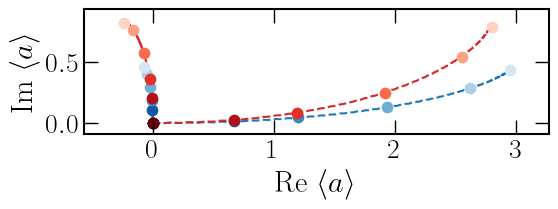

In [5]:
%matplotlib inline

x_list = [0,0.5,1,2,4,8]

norm = mpl.colors.Normalize(vmin=0, vmax=len(x_list))

cmap_b = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('Blues').reversed())
cmap_b.set_array([])

cmap_r = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('Reds').reversed())
cmap_r.set_array([])

cmap = [cmap_b, cmap_r]

fig, ax = plt.subplots(figsize=(6,6), dpi=100)

color = ['tab:blue','tab:red']

for q_idx,index in enumerate(qubit_state_list):
    ax.plot(exp_a[index].real,exp_a[index].imag, c=color[index], zorder=0)
    ax.plot(exp_a_disp[index].real,exp_a_disp[index].imag, c=color[index], ls='--', zorder=0)

    for ii,i in enumerate(x_list):
        idx = np.where(np.abs(tlist*kappa-i)<0.01)[0][0]
        ax.scatter(exp_a_an[index][idx].real, exp_a_an[index][idx].imag, color=cmap[q_idx].to_rgba(ii), s=55, zorder=1)
        ax.scatter(exp_a_an_disp[index][idx].real, exp_a_an_disp[index][idx].imag, color=cmap[q_idx].to_rgba(ii), s=55, zorder=1)

ax.set_xmargin(0.1)
ax.set_ymargin(0.1)

ax.xaxis.set_tick_params(direction="in", which='both')
ax.yaxis.set_tick_params(direction="in", which='both')

#ax.text(0.54,0.3,r'$\pmb{\left\vert + \right\rangle}$', ha='right', va='top', transform=ax.transAxes, color = 'tab:red', \
        #fontsize=16)
#ax.text(0.54,0.8,r'$\pmb{\left\vert - \right\rangle}$', ha='right', va='top', transform=ax.transAxes, color = 'tab:blue', \
        #fontsize=16)

ax.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True,
                  labelbottom=True, labelright=False, labeltop=False, which='both')

ax.set_xlabel(r'Re $\langle a \rangle$')
ax.set_ylabel(r'Im $\langle a \rangle$')

ax.set_aspect('equal')